# Spectral Methods with Chebyshev Polynomials

## Introduction

Spectral methods are a class of numerical techniques for solving differential equations that approximate solutions using global basis functions. Unlike finite difference or finite element methods that use local approximations, spectral methods expand the solution in terms of orthogonal polynomials or trigonometric functions, achieving **exponential convergence** for smooth problems.

**Chebyshev polynomials** are particularly well-suited for spectral methods on bounded domains due to their optimal interpolation properties and their connection to the minimax approximation problem.

## Mathematical Foundation

### Chebyshev Polynomials of the First Kind

The Chebyshev polynomials $T_n(x)$ are defined on the interval $[-1, 1]$ by the recurrence relation:

$$T_0(x) = 1, \quad T_1(x) = x$$

$$T_{n+1}(x) = 2x T_n(x) - T_{n-1}(x), \quad n \geq 1$$

Equivalently, they can be expressed using the trigonometric definition:

$$T_n(x) = \cos(n \arccos(x)), \quad x \in [-1, 1]$$

### Orthogonality

Chebyshev polynomials are orthogonal with respect to the weight function $w(x) = (1 - x^2)^{-1/2}$:

$$\int_{-1}^{1} \frac{T_m(x) T_n(x)}{\sqrt{1 - x^2}} dx = \begin{cases} 0 & m \neq n \\ \pi & m = n = 0 \\ \pi/2 & m = n \neq 0 \end{cases}$$

### Chebyshev-Gauss-Lobatto Points

For spectral collocation methods, we use the **Chebyshev-Gauss-Lobatto** (CGL) points:

$$x_j = \cos\left(\frac{\pi j}{N}\right), \quad j = 0, 1, \ldots, N$$

These points cluster near the boundaries, which helps avoid the **Runge phenomenon** in polynomial interpolation.

### Differentiation Matrix

The key advantage of spectral methods is the ability to compute derivatives through matrix multiplication. For a function $u(x)$ sampled at CGL points, the derivative is:

$$u'(x_i) = \sum_{j=0}^{N} D_{ij} u(x_j)$$

where $D$ is the **Chebyshev differentiation matrix** with entries:

$$D_{ij} = \begin{cases} \frac{c_i}{c_j} \frac{(-1)^{i+j}}{x_i - x_j} & i \neq j \\ -\frac{x_j}{2(1 - x_j^2)} & 1 \leq i = j \leq N-1 \\ \frac{2N^2 + 1}{6} & i = j = 0 \\ -\frac{2N^2 + 1}{6} & i = j = N \end{cases}$$

where $c_0 = c_N = 2$ and $c_i = 1$ for $i = 1, \ldots, N-1$.

## Applications

In this notebook, we will:
1. Construct Chebyshev polynomials and visualize them
2. Build the Chebyshev differentiation matrix
3. Solve a boundary value problem using spectral collocation
4. Demonstrate the exponential convergence of spectral methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

# Set plot style
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13

## Part 1: Chebyshev Polynomials

We first implement functions to generate Chebyshev polynomials using the recurrence relation and visualize the first several polynomials.

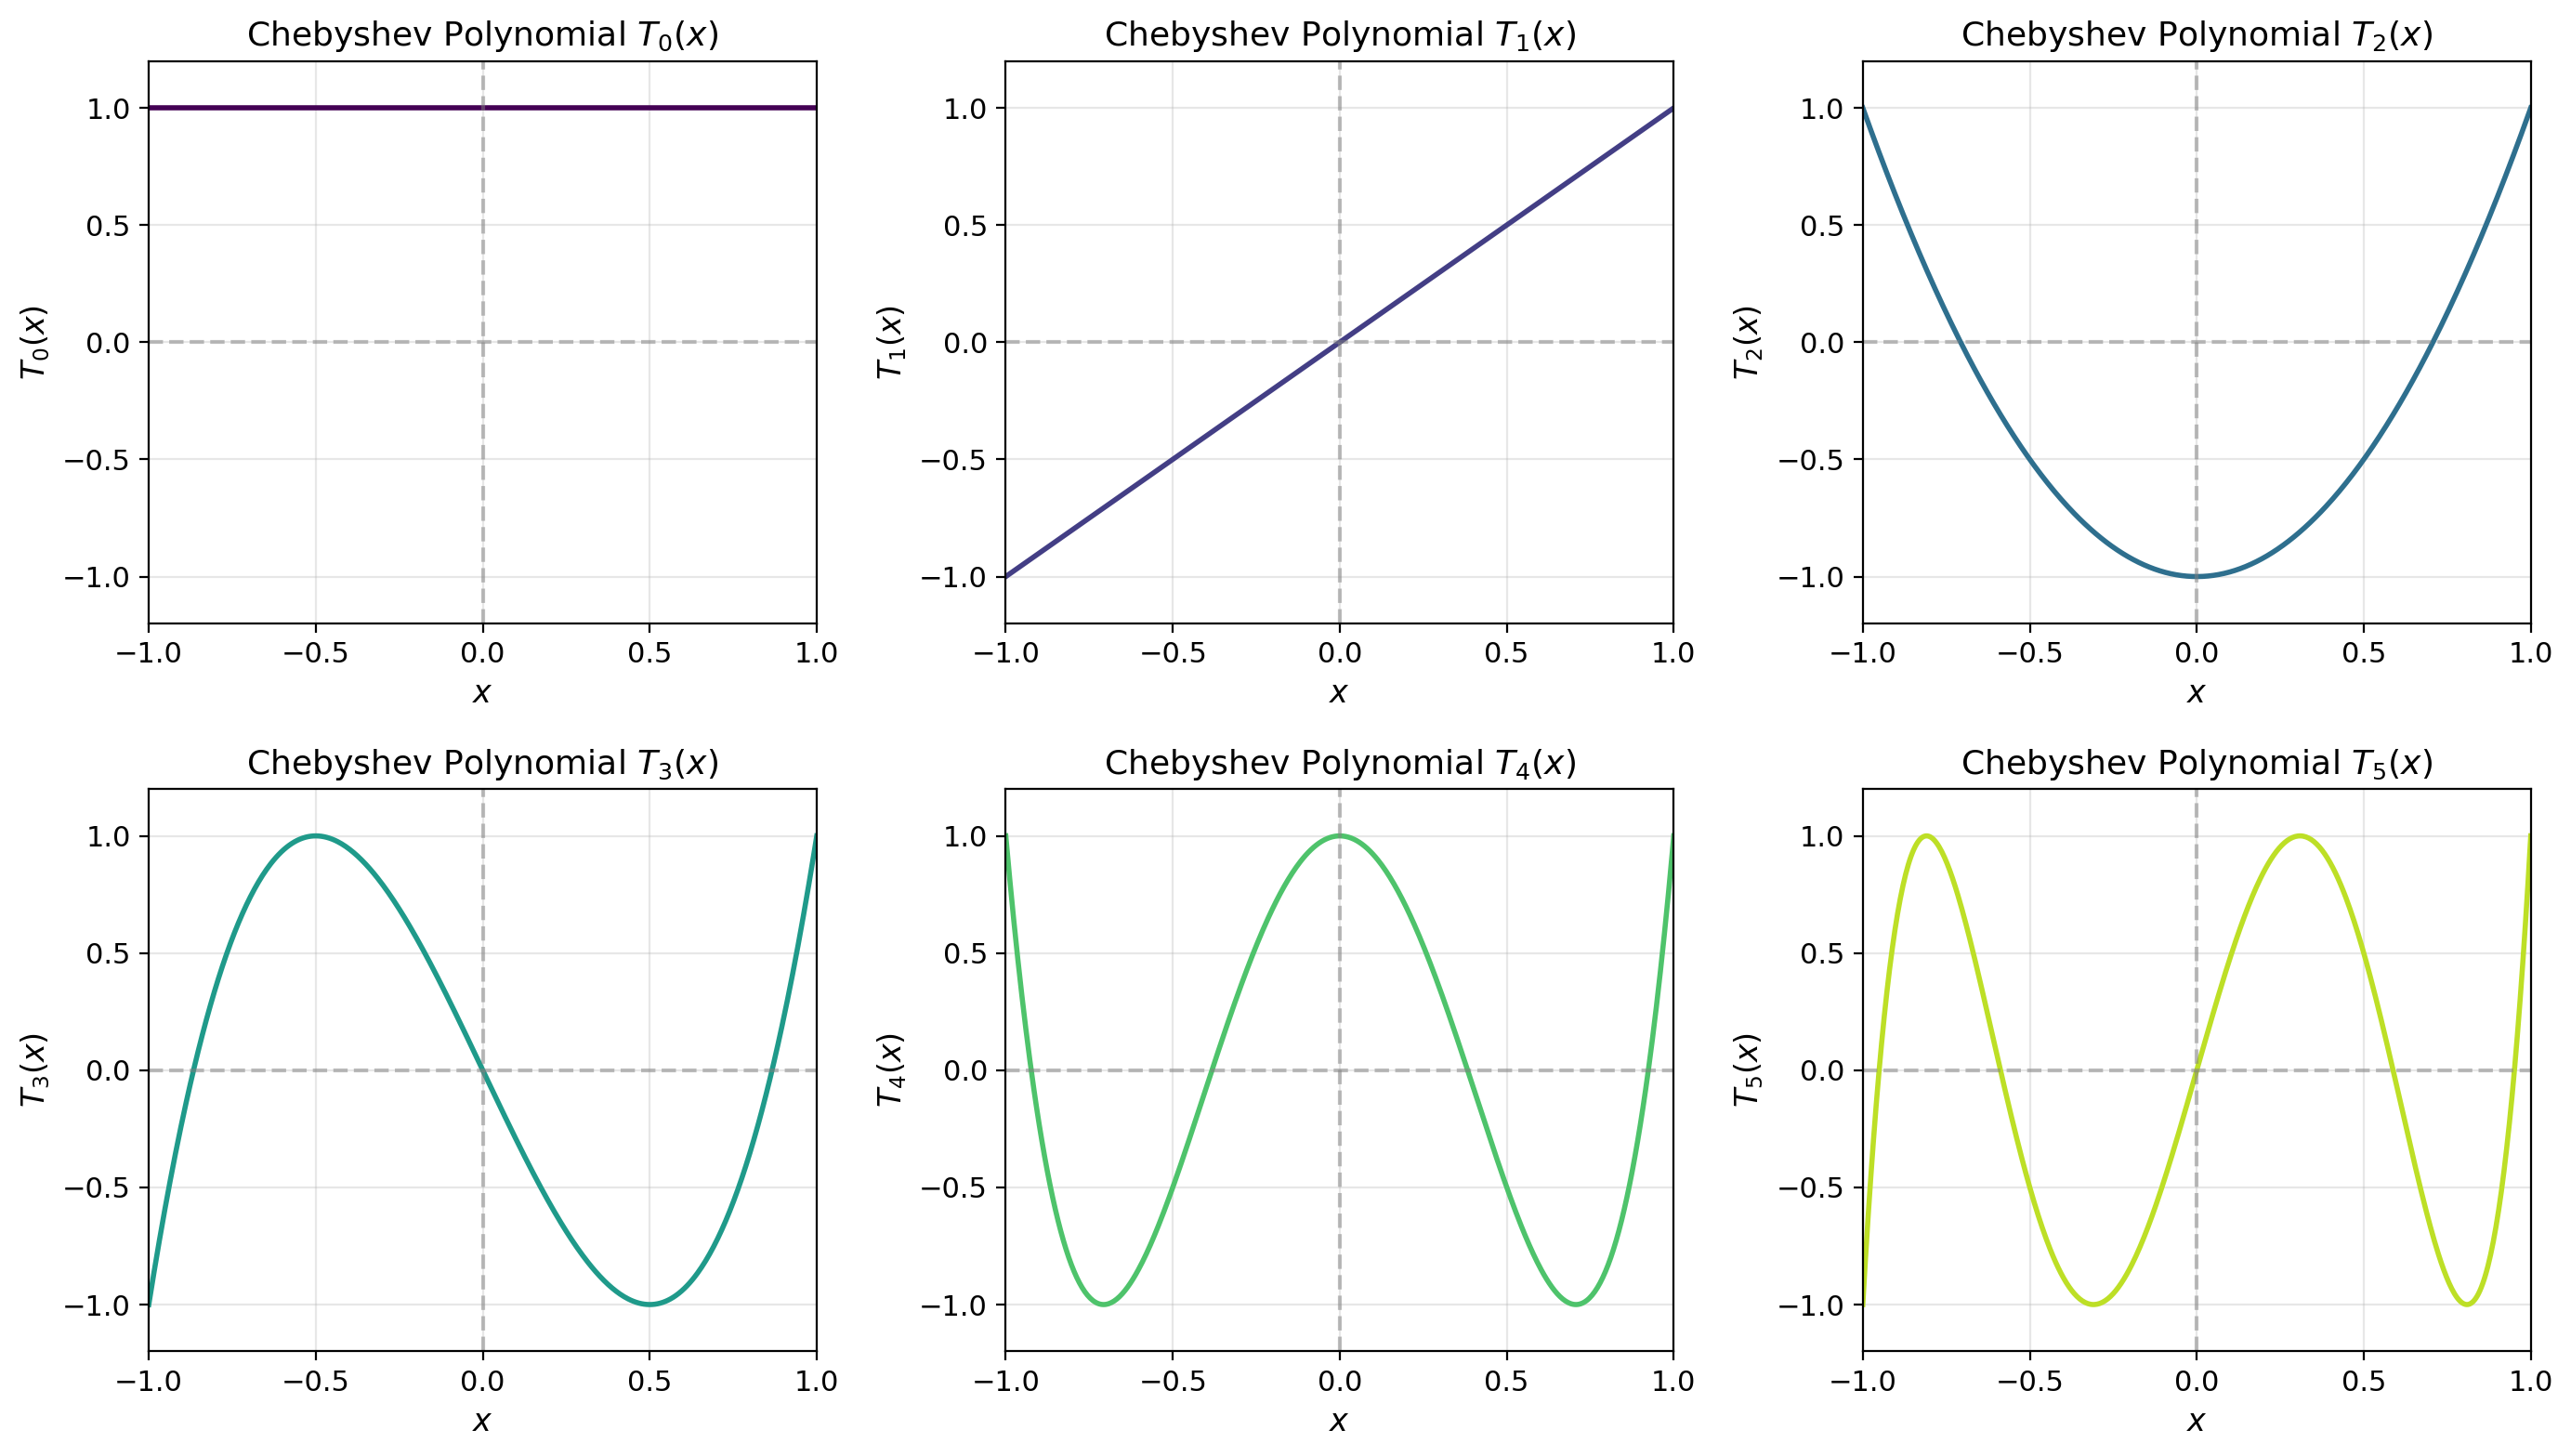

First 6 Chebyshev polynomials plotted.


In [2]:
def chebyshev_polynomial(n, x):
    """
    Compute Chebyshev polynomial T_n(x) using the recurrence relation.
    
    Parameters:
        n : int - degree of polynomial
        x : array - evaluation points
    
    Returns:
        T_n(x) : array - polynomial values
    """
    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return x.copy()
    else:
        T_prev = np.ones_like(x)  # T_0
        T_curr = x.copy()         # T_1
        for k in range(2, n + 1):
            T_next = 2 * x * T_curr - T_prev
            T_prev = T_curr
            T_curr = T_next
        return T_curr

# Generate evaluation points
x = np.linspace(-1, 1, 500)

# Plot first 6 Chebyshev polynomials
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

colors = plt.cm.viridis(np.linspace(0, 0.9, 6))

for n in range(6):
    ax = axes[n]
    T_n = chebyshev_polynomial(n, x)
    ax.plot(x, T_n, color=colors[n], linewidth=2)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel(f'$T_{n}(x)$')
    ax.set_title(f'Chebyshev Polynomial $T_{n}(x)$')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1.2, 1.2)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('chebyshev_polynomials.png', dpi=150, bbox_inches='tight')
plt.show()

print("First 6 Chebyshev polynomials plotted.")

## Part 2: Chebyshev-Gauss-Lobatto Points and Differentiation Matrix

The CGL points are the extrema of $T_N(x)$ and include the boundary points $x = \pm 1$. We now construct the differentiation matrix.

In [3]:
def chebyshev_nodes(N):
    """
    Generate Chebyshev-Gauss-Lobatto points.
    
    Parameters:
        N : int - polynomial degree (N+1 points)
    
    Returns:
        x : array of shape (N+1,) - CGL points in descending order
    """
    j = np.arange(N + 1)
    x = np.cos(np.pi * j / N)
    return x

def chebyshev_diff_matrix(N):
    """
    Construct the Chebyshev differentiation matrix.
    
    Parameters:
        N : int - polynomial degree
    
    Returns:
        D : array of shape (N+1, N+1) - differentiation matrix
        x : array of shape (N+1,) - CGL points
    """
    x = chebyshev_nodes(N)
    
    # Coefficients c_i
    c = np.ones(N + 1)
    c[0] = 2
    c[N] = 2
    
    # Initialize differentiation matrix
    D = np.zeros((N + 1, N + 1))
    
    for i in range(N + 1):
        for j in range(N + 1):
            if i != j:
                D[i, j] = (c[i] / c[j]) * ((-1) ** (i + j)) / (x[i] - x[j])
            elif i == 0:
                D[i, j] = (2 * N**2 + 1) / 6
            elif i == N:
                D[i, j] = -(2 * N**2 + 1) / 6
            else:
                D[i, j] = -x[j] / (2 * (1 - x[j]**2))
    
    return D, x

# Demonstrate with N=8
N = 8
D, x_nodes = chebyshev_diff_matrix(N)

print(f"Chebyshev-Gauss-Lobatto points for N={N}:")
print(x_nodes)
print(f"\nDifferentiation matrix D (shape {D.shape}):")
print(np.round(D, 3))

Chebyshev-Gauss-Lobatto points for N=8:
[ 1.00000000e+00  9.23879533e-01  7.07106781e-01  3.82683432e-01
  6.12323400e-17 -3.82683432e-01 -7.07106781e-01 -9.23879533e-01
 -1.00000000e+00]

Differentiation matrix D (shape (9, 9)):
[[ 21.5   -26.274   6.828  -3.24    2.     -1.446   1.172  -1.04    0.5  ]
 [  6.569  -3.154  -4.613   1.848  -1.082   0.765  -0.613   0.541  -0.26 ]
 [ -1.707   4.613  -0.707  -3.082   1.414  -0.918   0.707  -0.613   0.293]
 [  0.81   -1.848   3.082  -0.224  -2.613   1.307  -0.918   0.765  -0.362]
 [ -0.5     1.082  -1.414   2.613  -0.     -2.613   1.414  -1.082   0.5  ]
 [  0.362  -0.765   0.918  -1.307   2.613   0.224  -3.082   1.848  -0.81 ]
 [ -0.293   0.613  -0.707   0.918  -1.414   3.082   0.707  -4.613   1.707]
 [  0.26   -0.541   0.613  -0.765   1.082  -1.848   4.613   3.154  -6.569]
 [ -0.5     1.04   -1.172   1.446  -2.      3.24   -6.828  26.274 -21.5  ]]


## Part 3: Spectral Differentiation Accuracy

Let us verify the accuracy of spectral differentiation by differentiating the function $f(x) = e^{\sin(\pi x)}$ and comparing with the exact derivative.

In [4]:
def test_spectral_differentiation():
    """
    Test spectral differentiation accuracy for f(x) = exp(sin(pi*x)).
    """
    # Test function and its exact derivative
    f = lambda x: np.exp(np.sin(np.pi * x))
    df_exact = lambda x: np.pi * np.cos(np.pi * x) * np.exp(np.sin(np.pi * x))
    
    N_values = [4, 8, 16, 32, 64]
    errors = []
    
    for N in N_values:
        D, x = chebyshev_diff_matrix(N)
        
        # Function values at CGL points
        f_vals = f(x)
        
        # Spectral derivative
        df_spectral = D @ f_vals
        
        # Exact derivative at CGL points
        df_exact_vals = df_exact(x)
        
        # Maximum error
        error = np.max(np.abs(df_spectral - df_exact_vals))
        errors.append(error)
        print(f"N = {N:3d}: max error = {error:.2e}")
    
    return N_values, errors

N_values, errors = test_spectral_differentiation()

N =   4: max error = 4.52e+00
N =   8: max error = 4.94e-01
N =  16: max error = 5.05e-03
N =  32: max error = 4.62e-08
N =  64: max error = 2.35e-11


## Part 4: Solving a Boundary Value Problem

We now apply spectral collocation to solve the boundary value problem:

$$-u''(x) + u(x) = f(x), \quad x \in [-1, 1]$$
$$u(-1) = 0, \quad u(1) = 0$$

We choose $f(x)$ such that the exact solution is $u(x) = (1 - x^2) e^x$.

Substituting into the ODE:
$$u(x) = (1-x^2)e^x$$
$$u'(x) = (-2x + 1 - x^2)e^x$$
$$u''(x) = (-4x - x^2 + 1 - 2)e^x = (-x^2 - 4x - 1)e^x$$

Therefore:
$$f(x) = -u''(x) + u(x) = (x^2 + 4x + 1)e^x + (1-x^2)e^x = (2 + 4x)e^x$$

In [5]:
def solve_bvp_spectral(N):
    """
    Solve -u'' + u = f with homogeneous Dirichlet BCs using spectral collocation.
    
    Parameters:
        N : int - polynomial degree
    
    Returns:
        x : array - CGL points
        u : array - numerical solution
        u_exact : array - exact solution
        error : float - maximum error
    """
    # Exact solution and source term
    u_exact_func = lambda x: (1 - x**2) * np.exp(x)
    f_func = lambda x: (2 + 4*x) * np.exp(x)
    
    # Build differentiation matrices
    D, x = chebyshev_diff_matrix(N)
    D2 = D @ D  # Second derivative matrix
    
    # Construct the operator: -D2 + I
    I = np.eye(N + 1)
    L = -D2 + I
    
    # Right-hand side
    rhs = f_func(x)
    
    # Apply boundary conditions by modifying rows 0 and N
    # u(x_0) = u(1) = 0 and u(x_N) = u(-1) = 0
    L[0, :] = 0
    L[0, 0] = 1
    rhs[0] = 0
    
    L[N, :] = 0
    L[N, N] = 1
    rhs[N] = 0
    
    # Solve the linear system
    u = solve(L, rhs)
    
    # Exact solution at CGL points
    u_exact = u_exact_func(x)
    
    # Maximum error
    error = np.max(np.abs(u - u_exact))
    
    return x, u, u_exact, error

# Solve with different N values to show convergence
print("Convergence study for BVP: -u'' + u = f")
print("="*50)

N_values_bvp = [4, 8, 12, 16, 20, 24, 28, 32]
errors_bvp = []

for N in N_values_bvp:
    x, u, u_exact, error = solve_bvp_spectral(N)
    errors_bvp.append(error)
    print(f"N = {N:3d}: max error = {error:.2e}")

# Detailed solution for N=16
x_sol, u_sol, u_exact_sol, _ = solve_bvp_spectral(16)

Convergence study for BVP: -u'' + u = f
N =   4: max error = 9.90e-03
N =   8: max error = 4.78e-07
N =  12: max error = 2.39e-12


N =  16: max error = 5.79e-15
N =  20: max error = 1.33e-15
N =  24: max error = 7.79e-15
N =  28: max error = 9.99e-15
N =  32: max error = 2.00e-14


## Part 5: Visualization and Convergence Analysis

We now create a comprehensive visualization showing:
1. The Chebyshev-Gauss-Lobatto point distribution
2. The BVP solution comparison
3. The convergence rate (exponential convergence)

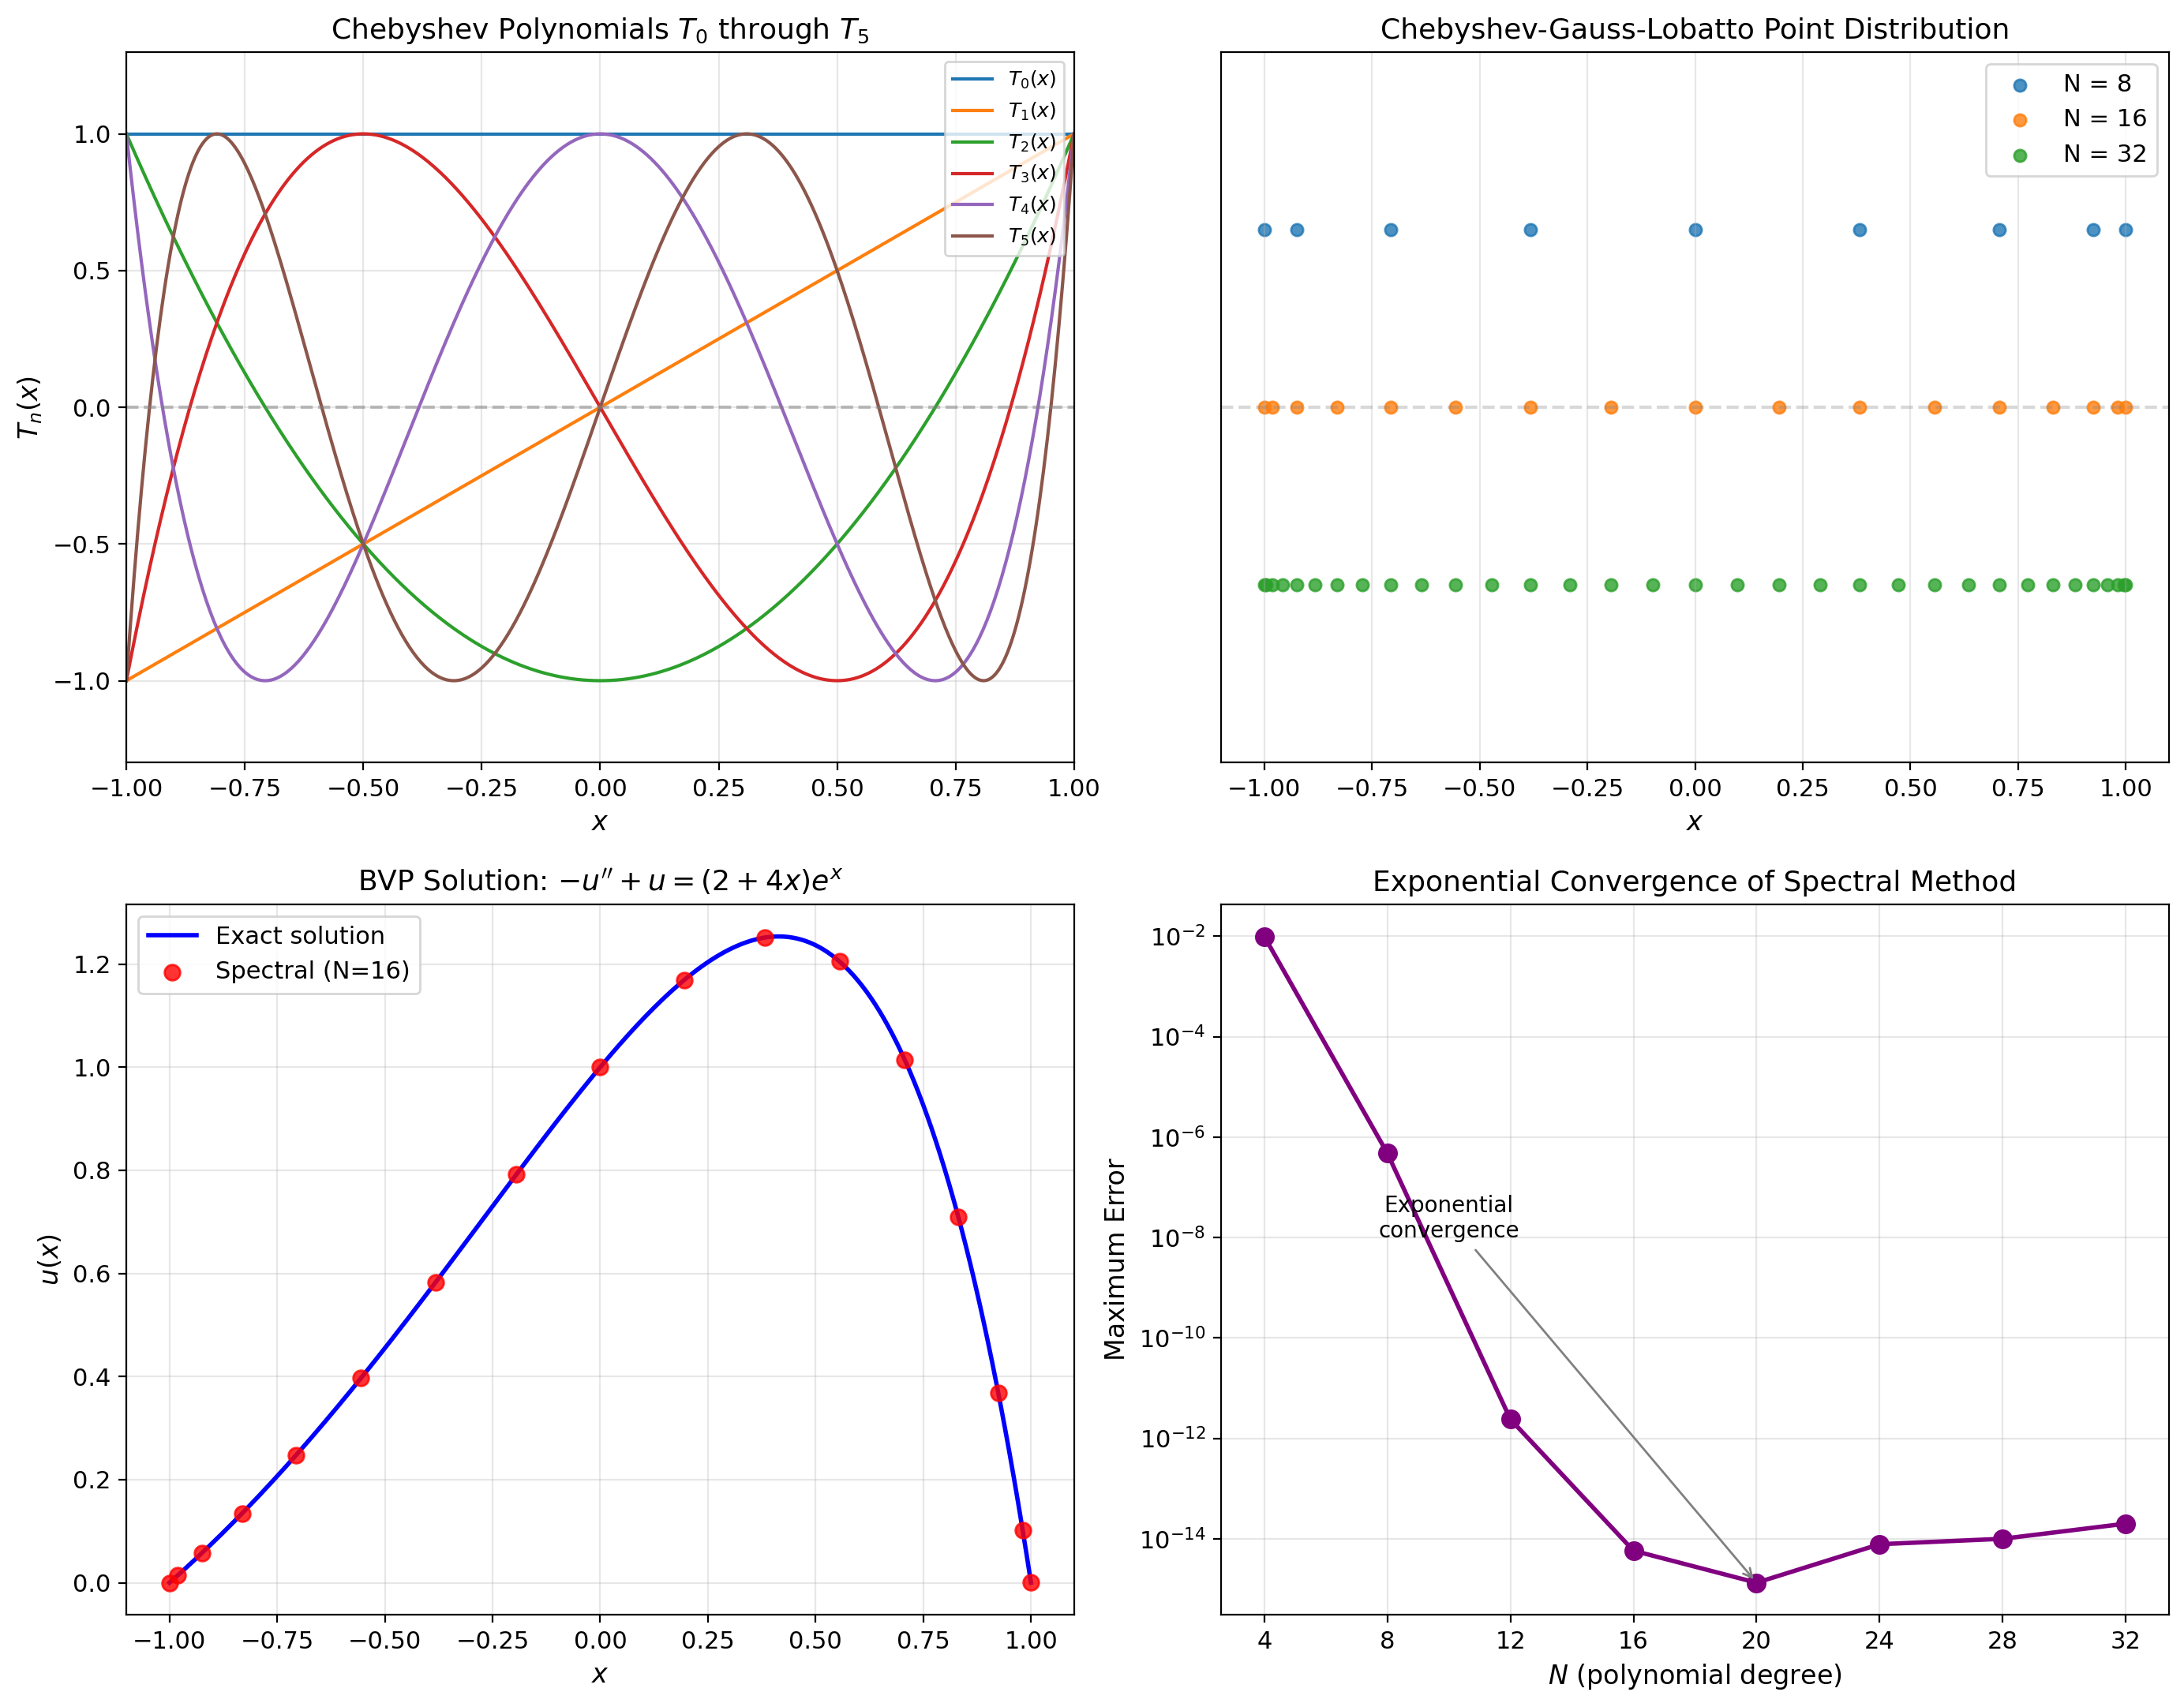


Figure saved to plot.png


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# Panel 1: Chebyshev polynomials overlay
ax1 = axes[0, 0]
x_fine = np.linspace(-1, 1, 500)
for n in range(6):
    T_n = chebyshev_polynomial(n, x_fine)
    ax1.plot(x_fine, T_n, label=f'$T_{n}(x)$', linewidth=1.5)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$T_n(x)$')
ax1.set_title('Chebyshev Polynomials $T_0$ through $T_5$')
ax1.legend(loc='upper right', fontsize=9)
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1.3, 1.3)
ax1.grid(True, alpha=0.3)

# Panel 2: CGL points distribution
ax2 = axes[0, 1]
for N in [8, 16, 32]:
    x_cgl = chebyshev_nodes(N)
    y_offset = {8: 0.3, 16: 0.0, 32: -0.3}[N]
    ax2.scatter(x_cgl, np.ones_like(x_cgl) * y_offset, s=30, label=f'N = {N}', alpha=0.8)
ax2.set_xlabel('$x$')
ax2.set_title('Chebyshev-Gauss-Lobatto Point Distribution')
ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-0.6, 0.6)
ax2.legend()
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax2.set_yticks([])
ax2.grid(True, alpha=0.3, axis='x')

# Panel 3: BVP solution
ax3 = axes[1, 0]
x_plot = np.linspace(-1, 1, 200)
u_exact_plot = (1 - x_plot**2) * np.exp(x_plot)
ax3.plot(x_plot, u_exact_plot, 'b-', linewidth=2, label='Exact solution')
ax3.scatter(x_sol, u_sol, color='red', s=50, zorder=5, label=f'Spectral (N=16)', alpha=0.8)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$u(x)$')
ax3.set_title(r'BVP Solution: $-u^{\prime\prime} + u = (2+4x)e^x$')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Panel 4: Convergence analysis
ax4 = axes[1, 1]
ax4.semilogy(N_values_bvp, errors_bvp, 'o-', linewidth=2, markersize=8, color='purple')
ax4.set_xlabel('$N$ (polynomial degree)')
ax4.set_ylabel('Maximum Error')
ax4.set_title('Exponential Convergence of Spectral Method')
ax4.grid(True, alpha=0.3, which='both')
ax4.set_xticks(N_values_bvp)

# Add annotation about exponential convergence
ax4.annotate('Exponential\nconvergence', xy=(20, errors_bvp[4]), xytext=(10, 1e-8),
             arrowprops=dict(arrowstyle='->', color='gray'),
             fontsize=10, ha='center')

plt.tight_layout()
plt.savefig('plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to plot.png")

## Summary

In this notebook, we explored **spectral methods** using **Chebyshev polynomials**:

1. **Chebyshev Polynomials**: Defined via the recurrence relation $T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)$, these polynomials form an orthogonal basis with respect to the weight $(1-x^2)^{-1/2}$.

2. **Chebyshev-Gauss-Lobatto Points**: The collocation points $x_j = \cos(\pi j/N)$ cluster near boundaries, providing optimal interpolation properties.

3. **Differentiation Matrix**: The Chebyshev differentiation matrix allows derivatives to be computed via matrix-vector multiplication, achieving spectral accuracy.

4. **Exponential Convergence**: For smooth problems, spectral methods achieve errors that decay exponentially with $N$, far surpassing the algebraic convergence of finite difference methods ($O(h^p)$).

### Key Advantages of Spectral Methods

- **Exponential convergence** for analytic functions
- **High accuracy** with relatively few degrees of freedom
- **Global approximation** captures smooth features efficiently

### Limitations

- Less suitable for problems with discontinuities (Gibbs phenomenon)
- Requires careful treatment of complex geometries
- Dense matrices can be costly for very large problems

Spectral methods are the method of choice for problems demanding high accuracy, such as direct numerical simulation of turbulence, weather prediction, and quantum chemistry calculations.